In [27]:
import numpy as np
from orphics import maps, cosmology,io,stats
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
#from IPython.display import set_matplotlib_formats set_matplotlib_formats('retina')
csfont = {'fontname':'Latin Modern Roman'}
font = font_manager.FontProperties(family='Latin Modern Roman',style='normal', size = 8)
#from cosmo_cleaner import fisher

def get_corrcoef(clgg,clcibcib,clkk,clkg,clcibk,clcibg):
    rho={}
    rho_gk=np.sqrt(clkg**2/(clgg*clkk))
    rho_gcib=np.sqrt(clcibg**2/(clcibcib*clgg))
    rho_kcib=np.sqrt(clcibk**2/(clcibcib*clkk))
    rho['gk']=rho_gk
    rho['gcib']=rho_gcib
    rho['kcib']=rho_kcib
    return rho

#create forecaster class

#receive spectra as a dict

class Fisher():
    def __init__(self, fsky,Npars, ells, spectra, der_spectra):
        self.spectra=spectra
        self.fsky=fsky
        self.der_spectra=der_spectra
        self.Npars=Npars
        self.ells=ells
        #function to get the number of modes
        
    def get_modes(self):
        
        deltaL=np.zeros(len(self.ells))
        deltaL[0]=self.ells[0]-0
        deltaL[1:]=self.ells[1:]-self.ells[:-1] 
        result = (2*self.ells*deltaL*self.fsky)
        return 1/result

    def get_Cl(self,X,Y):
        """X:g,k,i
           Y:g,k,i
        """
        if X+Y in self.spectra:
            Cl=self.spectra[X+Y]
        elif Y+X in self.spectra:
            Cl=self.spectra[Y+X]
        else:
            #field not present assume its zero and do not return error
            Cl=np.zeros(len(self.ells))
        return Cl

    def get_cov(self,X,Y,W,Z):
        return self.get_modes()*(self.get_Cl(X,W)*self.get_Cl(Y,Z)+self.get_Cl(X,Z)*self.get_Cl(Y,W))

    def get_covmat(self):
        self.covmat=np.zeros((len(self.ells),len(self.spectra),len(self.spectra)))
        self.cov_dict = {}
        for i in range(len(self.spectra)): 
            for j in range(len(self.spectra)):
                X,Y=list(self.spectra)[i]
                W,Z=list(self.spectra)[j]
                self.covmat[:,i,j]=self.get_cov(X,Y,W,Z)
                self.cov_dict[list(self.spectra)[i]+','+list(self.spectra)[j]]= self.get_cov(X,Y,W,Z)
        return self.covmat
    
    def get_fisher(self):
        
        #derivatives check shape (ells,len(spectra),len(pars))
        assert(self.der_spectra.shape[0] == len(self.ells)) 
        assert(self.der_spectra.shape[1] == len(self.spectra)) 
        assert(self.der_spectra.shape[2] == self.Npars)
        fisher_per_mode = np.einsum('...ik, ...ij, ...jm -> ...km',self.der_spectra, np.nan_to_num(np.linalg.inv(self.get_covmat())), self.der_spectra)
        self.fisher_per_mode=fisher_per_mode
        self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)
        
        self.fisher=np.sum(self.fisher_per_mode,axis=0)
        self.error_non_marginalized = np.diag(self.fisher)**-0.5 
        self.error_marginalized = np.linalg.inv(self.fisher)**0.5
        
        return self.error_marginalized[0]
    
def compare_cleaning(clgg,clcibcib,clkk,clkg,clcibk,clcibg,bias,ellrange,cut=500,fsky=1):
    clgg0=clgg/bias**2
    clkg0=clkg/bias
    clcibg0=clcibg/bias
    ellrange=ellrange[:cut]

    clgg0=clgg/bias**2
    clkg0=clkg/bias
    clcibg0=clcibg/bias
    ellrange=ellrange[:cut]

    #calculate the base error
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': clkk[:cut]}
    pars = ['b','omega']#, 's'
    Npars = len(pars)
    der_spectra_alpha = np.ones((len(clkg[:cut]), len(spectra), Npars))
    #Derivatives with respect to b
    der_spectra_alpha[:, 0, 0] = clkg0[:cut]
    der_spectra_alpha[:, 1, 0] = 2*bias*clgg0[:cut]
    der_spectra_alpha[:, 2, 0] = np.zeros((len(clkg[:cut])))
    #derivatives wrt to omega
    der_spectra_alpha[:, 0, 1] = 2*bias*clkg0[:cut]
    der_spectra_alpha[:, 1, 1] = 2*bias**2*clgg0[:cut]
    der_spectra_alpha[:, 2, 1] = 2*clkk[:cut]

    a=Fisher(1,2,ellrange,spectra,der_spectra_alpha)
    old=a.get_fisher()[0]
    oldf=a.error_per_mode_non_marginalized
    
    clkk_n=clkk-clcibk**2/clcibcib
    #calculate the base error
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': clkk_n[:cut]}
    pars = ['b','omega']#, 's'
    Npars = len(pars)
    der_spectra_alpha = np.ones((len(clkg[:cut]), len(spectra), Npars))
    #Derivatives with respect to b
    der_spectra_alpha[:, 0, 0] = clkg0[:cut]
    der_spectra_alpha[:, 1, 0] = 2*bias*clgg0[:cut]
    der_spectra_alpha[:, 2, 0] = np.zeros((len(clkg[:cut])))
    #derivatives wrt to omega
    der_spectra_alpha[:, 0, 1] = 2*bias*clkg0[:cut]
    der_spectra_alpha[:, 1, 1] = 2*bias**2*clgg0[:cut]
    der_spectra_alpha[:, 2, 1] = 2*(clkk_n[:cut]-(clcibk**2/clcibcib)[:cut])

    a=Fisher(1,2,ellrange,spectra,der_spectra_alpha)
    new=a.get_fisher()[0]
    newf=a.error_per_mode_non_marginalized
    #print(f'{100*(old-new)/old} % improvement with cleaning')
    return (100*(old-new)/old,old,new,oldf,newf)   

In [3]:
l1c = cosmology.LimberCosmology(lmax=2000,pickling=True)

Generating theory Cls...
initializing power...
Initializing CMB window..


In [5]:
#specify the redshifts
z_edges = np.arange(0.,4.0,0.01)
zcents = (z_edges[1:]+z_edges[:-1])/2.
g1=np.zeros(len(zcents))
g2=np.zeros(len(zcents))
g3=np.zeros(len(zcents))

#g3 the external tracer. g1 the low z tracer
g1[zcents<0.3]=np.interp(zcents[zcents<0.3], l1c.zs, l1c.kernels['cmb']['W'])
g2=np.interp(zcents, l1c.zs, l1c.kernels['cmb']['W'])
g3[zcents>0.3]=np.interp(zcents[zcents>0.3], l1c.zs, l1c.kernels['cmb']['W'])

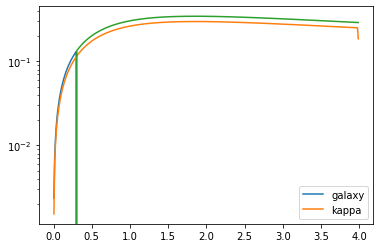

In [20]:
#plt.semilogy(zcents,g1)
plt.plot(zcents,g1,label='galaxy')
plt.plot(zcents,np.interp(zcents, l1c.zs, l1c.kernels['g2']['W']),label='kappa')
plt.semilogy(zcents,g3)
plt.legend()

('Initializing galaxy window for ', 'g1', ' ...')
('Initializing galaxy window for ', 'g2', ' ...')
('Initializing galaxy window for ', 'g3', ' ...')


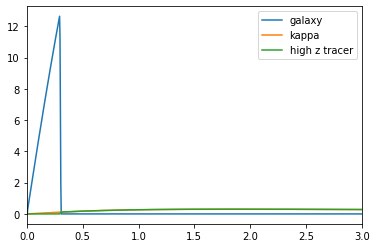

In [7]:

# Let's add this dndz to the cosmology object. By default, LimberCosmology doesn't allow you to reuse tag names, but here we force it to since this is a Python notebook!
l1c.addNz("g1",zcents,g1,bias=2,ignore_exists=True)
l1c.addNz("g2",zcents,g2,bias=1,ignore_exists=True)
l1c.addNz("g3",zcents,g3,bias=1,ignore_exists=True)

# and plot the resulting lensing kernel

plt.figure()
plt.plot(l1c.zs,l1c.kernels["g1"]['W'],label='galaxy')
#plt.plot(l1c.zs,l1c.kernels["g2"]['W'],label='g2')
plt.plot(l1c.zs,l1c.kernels["g2"]['W'],label='kappa')
#plt.plot(l1c.zs,l1c.kernels["g3"]['W'],label='high z tracer')
plt.plot(l1c.zs,l1c.kernels["g3"]['W'],label='high z tracer')

plt.legend()
plt.xlim(0,3)
plt.show()

In [23]:
corr=get_corrcoef(clgg,clcibcib,clkk,clkg,clcibk,clcibg)

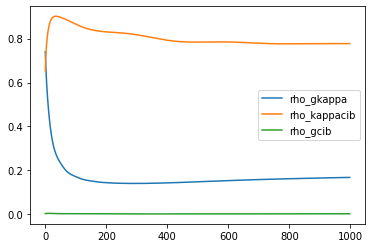

In [24]:
plt.plot(corr['gk'],label='rho_gkappa')
plt.plot(corr['kcib'],label='rho_kappacib')
plt.plot(corr['gcib'],label='rho_gcib')
#plt.hlines(1,0,1000)
plt.legend()

In [25]:
corrnew=get_corrcoef(clgg,clcibcib,clkk-clcibk**2/clcibcib,clkg,clcibk,clcibg)

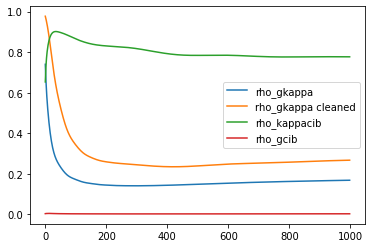

In [26]:
plt.plot(corr['gk'],label='rho_gkappa')
plt.plot(corrnew['gk'],label='rho_gkappa cleaned')
plt.plot(corr['kcib'],label='rho_kappacib')
plt.plot(corrnew['gcib'],label='rho_gcib')
plt.legend()

In [18]:
ellrange = np.arange(1,1000)
l1c.generateCls(ellrange)
bias=2
omega_8=0.2
clkk = l1c.getCl("cmb","cmb") 
clgg = l1c.getCl("g1","g1") 
clcibcib = l1c.getCl("g3","g3") 
clkg = l1c.getCl("cmb","g1")
clcibg = l1c.getCl("g1","g3")
clcibk = l1c.getCl("cmb","g3")

clgg0=clgg/bias**2
clkg0=clkg/bias
clcibg0=clcibg/bias
improvement=[]
old=[]
new=[]
for i in range(1,1000):
    error=compare_cleaning(clgg,clcibcib,clkk,clkg,clcibk,clcibg,bias,ellrange,cut=i,fsky=1)
    improvement.append(error[0])
    old.append(error[3])
    new.append(error[4])

/home/r/rbond/jiaqu/.virtualenvs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in sqrt


Text(0.5, 0, 'Lcut used')

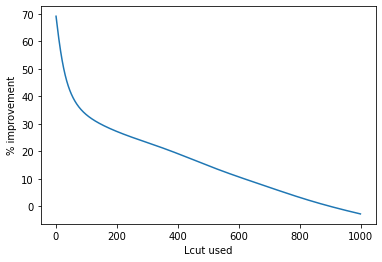

In [19]:
plt.plot(np.arange(1,1000),improvement)
plt.ylabel("% improvement")
plt.xlabel("Lcut used")

## more realistic model

In [146]:
def dndz_gauss(z,z0,sigma):
    ans = 1/np.sqrt(2*np.pi*sigma**2)* np.exp((-(z-z0)**2)/ (2.*sigma**2.))
 
    return ans 


In [150]:
z_edges = np.arange(0.,4.0,0.01)
zcents = (z_edges[1:]+z_edges[:-1])/2.
g1=0.5*dndz_gauss(zcents,0.4,0.2)
g1[zcents>1]=0.
g2=np.interp(zcents, l1c.zs, l1c.kernels['cmb']['W'])
g3=dndz_gauss(zcents,2,0.6)
g3[zcents<1]=0.

('Initializing galaxy window for ', 'g1', ' ...')
('Initializing galaxy window for ', 'g2', ' ...')
('Initializing galaxy window for ', 'g3', ' ...')


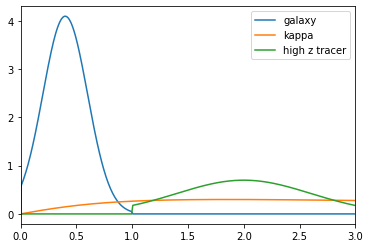

In [151]:

# Let's add this dndz to the cosmology object. By default, LimberCosmology doesn't allow you to reuse tag names, but here we force it to since this is a Python notebook!
l1c.addNz("g1",zcents,g1,bias=2,ignore_exists=True)
l1c.addNz("g2",zcents,g2,bias=1,ignore_exists=True)
l1c.addNz("g3",zcents,g3,bias=1,ignore_exists=True)

# and plot the resulting lensing kernel

plt.figure()
plt.plot(l1c.zs,l1c.kernels["g1"]['W'],label='galaxy')
#plt.plot(l1c.zs,l1c.kernels["g2"]['W'],label='g2')
plt.plot(l1c.zs,l1c.kernels["g2"]['W'],label='kappa')
#plt.plot(l1c.zs,l1c.kernels["g3"]['W'],label='high z tracer')
plt.plot(l1c.zs,l1c.kernels["g3"]['W'],label='high z tracer')

plt.legend()
plt.xlim(0,3)
plt.show()

In [152]:
ellrange = np.arange(1,1000)
l1c.generateCls(ellrange)
bias=2
clkk = l1c.getCl("cmb","cmb") 
clgg = l1c.getCl("g1","g1") 
clcibcib = l1c.getCl("g3","g3") 
clkg = l1c.getCl("cmb","g1")
clcibg = l1c.getCl("g1","g3")
clcibk = l1c.getCl("cmb","g3")

clgg0=clgg/bias**2
clkg0=clkg/bias
clcibg0=clcibg/bias

In [164]:
improvement=[]
old=[]
new=[]
for i in range(1,1000):
    error=compare_cleaning(clgg,clcibcib,clkk,clkg,clcibk,clcibg,bias,ellrange,cut=i,fsky=1)
    improvement.append(error[0])
    old.append(error[3])
    new.append(error[4])

Text(0.5, 0, 'Lcut used')

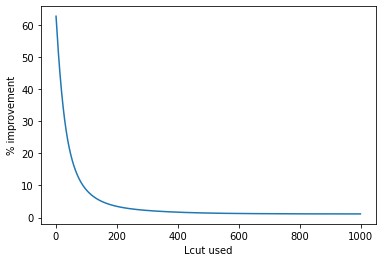

In [165]:
plt.plot(np.arange(1,1000),improvement)
plt.ylabel("% improvement")
plt.xlabel("Lcut used")